In [1]:
import os
import requests
import math
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime
import power_model_v2 as p
from nptyping import NDArray
import matplotlib.pyplot as plt

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
forecast_lenght = 365*1
start_date = datetime.date(2022, 10, 15) 
end_date = start_date + datetime.timedelta(days=forecast_lenght)
rb_power_zero = 16430
qa_power_zero = 18990

In [3]:
url = f"https://observable-api-test.starboard.ventures/getdata/sectors_schedule_expiration_full?start={str(start_date)}&end={str(end_date)}"
r = requests.get(url)

# Put data in dataframe
scheduled_df = pd.DataFrame(r.json()["data"])
scheduled_df

# Convert bytes to petabytes
pib_convertion = 2**50
scheduled_df["extended_rb"] = scheduled_df["extended_bytes"].astype(float)/pib_convertion
scheduled_df["expired_rb"] = scheduled_df["expired_bytes"].astype(float)/pib_convertion
scheduled_df["open_rb"] = scheduled_df["potential_expire_bytes"].astype(float)/pib_convertion
scheduled_df["extended_qa"] = scheduled_df["extended_bytes_qap"].astype(float)/pib_convertion
scheduled_df["expired_qa"] = scheduled_df["expired_bytes_qap"].astype(float)/pib_convertion
scheduled_df["open_qa"] = scheduled_df["potential_expire_bytes_qap"].astype(float)/pib_convertion

# Total scheduled to expire, excluding terminated
scheduled_df["total_rb"] = scheduled_df["extended_rb"]+scheduled_df["expired_rb"]+scheduled_df["open_rb"]
scheduled_df["total_qa"] = scheduled_df["extended_qa"]+scheduled_df["expired_qa"]+scheduled_df["open_qa"]

# Convert interest date to datetime
scheduled_df["date"] = pd.to_datetime(scheduled_df["interest_date"])

# Filter dates
scheduled_df = scheduled_df[scheduled_df["date"] >= pd.to_datetime(start_date, utc="UTC")]
scheduled_df = scheduled_df[scheduled_df["date"] < pd.to_datetime(end_date, utc="UTC")]

# Get array with the rb_known_scheduled_expire and qa_known_scheduled_expire_vec
rb_known_scheduled_expire_vec = scheduled_df["total_rb"].values
qa_known_scheduled_expire_vec = scheduled_df["total_qa"].values

In [4]:
# Get last beaseline value from Starboard API
url = f"https://observable-api.starboard.ventures/api/v1/observable/network-storage-capacity/new_baseline_power"
r = requests.get(url)
temp_df = pd.DataFrame(r.json()["data"])

temp_df["date"] = pd.to_datetime(temp_df["stat_date"])
init_baseline_bytes = int(temp_df[temp_df["date"] >= pd.to_datetime(start_date, utc="UTC")].iloc[0,1])
eib_convertion = 2**60
init_baseline = init_baseline_bytes/eib_convertion

# Baseline function
baseline_growth = float(math.log(2)/365.0)

baseline_df = pd.DataFrame({
    "index": np.arange(forecast_lenght).astype("float"),
    "date": pd.date_range(start=start_date, freq="d", periods=forecast_lenght),
})
baseline_df["total_power"] =  init_baseline * math.e**(baseline_growth*baseline_df["index"])
baseline_df["power_type"] = "baseline"
baseline_df = baseline_df[["date", "total_power", "power_type"]]

In [5]:
renewal_rate = 0.6
rb_onboard_power = 10.0
fil_plus_rate = 0.098
duration = 360

In [6]:
rb_power_df, qa_power_df = p.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)
qa_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)

df = pd.concat([rb_power_df, qa_power_df]).sort_values(["forecasting_step", "power_type"]).reset_index(drop=True)

In [7]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast - base scenario"
)

/var/folders/_t/17gdg2x95_s7vvqg6r69vbbc0000gn/T/ipykernel_38617/2084706379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source["total_power"] = source["total_power"]/1024.0


alt.Chart(...)

In [8]:
crossing_date = rb_power_df[rb_power_df["total_power"]/1024.0 < baseline_df["total_power"]]["date"].iloc[0].date()

print("Baseline crossing at", str(crossing_date))

Baseline crossing at 2023-02-15


In [9]:
MEGA = 1_000_100
EXA = 10**18
EXBI = 2**60
LAMBDA = 30 * 3.663258818 * 10**-9
SIMPLE_ALLOC = 0.3 * 1.1 * 10**9
BASELINE_ALLOC = 0.7 * 1.1 * 10**9
BASELINE_B0 = 2.88888888 * 10**18 # initial storage
BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
EPOCH_PER_DAY = 2880

In [10]:
def simple_reward_epoch(epoch: float)->float:
    '''
    Exponential decay simple reward
    '''
    return SIMPLE_ALLOC * LAMBDA * np.exp(-LAMBDA * epoch)

def baseline_storage(epoch: float)->float:
    '''
    Baseline storage target function
    epoch -- time in 30s second epochs since first mint

    '''
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

def baseline_reward(capped_power:NDArray, cum_capped_power:NDArray)->NDArray:
    '''
    Derivative of cum_baseline_reward_epoch
    '''
    a = BASELINE_ALLOC * LAMBDA / BASELINE_B0
    b = capped_power
    c = (1 + (BASELINE_R / BASELINE_B0) * cum_capped_power) ** (1 + LAMBDA / BASELINE_R)
    return a * b / c

def cum_simple_reward(epoch):
    '''
    Cumulative exponential decay simple reward
    '''
    return SIMPLE_ALLOC * (1 - np.exp(-LAMBDA * epoch))

def network_time(cum_capped_power):
    '''
    '''
    return np.log1p(BASELINE_R * cum_capped_power / BASELINE_B0) / BASELINE_R

def cum_baseline_reward_epoch(network_time):
    '''
    '''
    return BASELINE_ALLOC * (1 - np.exp(-LAMBDA * network_time))

<AxesSubplot:>

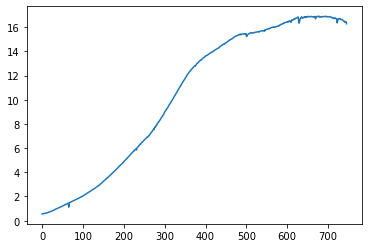

In [11]:
history_power_df = pd.read_csv('/Users/tom/Downloads/Network_Storage_Capacity.csv')
history_power_df['Total RB Capacity'].plot()

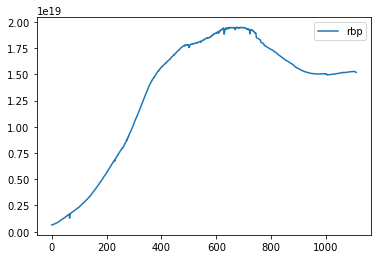

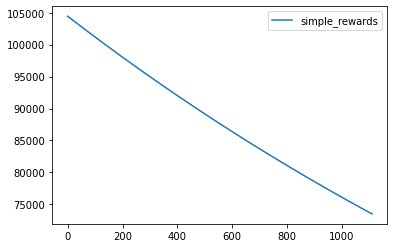

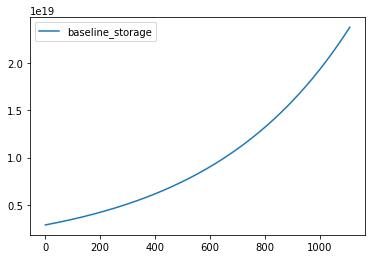

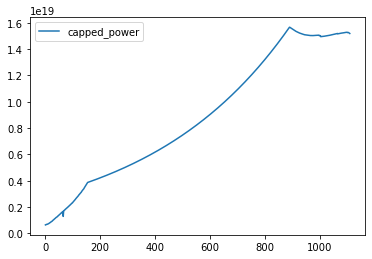

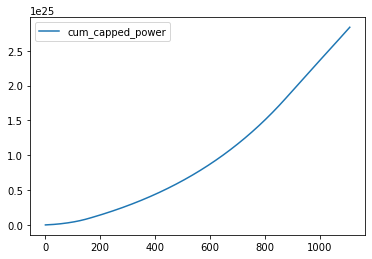

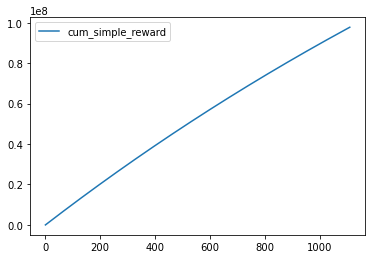

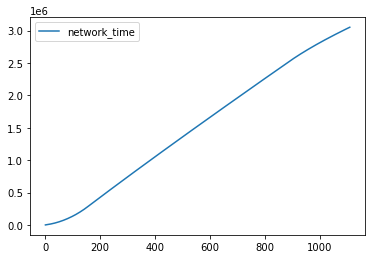

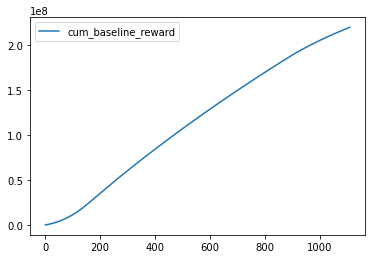

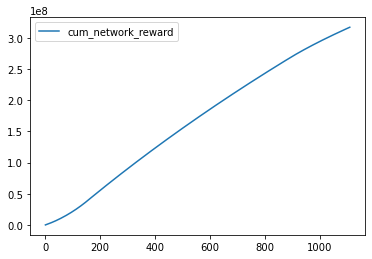

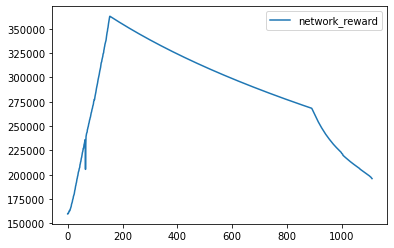

In [12]:
minting_df = pd.DataFrame()
minting_df['rbp'] = np.concatenate([history_power_df['Total RB Capacity'].values * 2 ** 60, 
                         rb_power_df['total_power'].values * 2 ** 50])
minting_df['rbp'].plot(label='rbp'); plt.legend(); plt.show()

minting_df['day_epoch'] = EPOCH_PER_DAY * np.array(list(minting_df.index))
minting_df['simple_reward_epoch'] = 2880 * minting_df['day_epoch'].pipe(simple_reward_epoch)
minting_df['simple_reward_epoch'].plot(label='simple_rewards'); plt.legend(); plt.show()

minting_df['baseline_storage'] = minting_df['day_epoch'].pipe(baseline_storage)
minting_df['baseline_storage'].plot(label='baseline_storage'); plt.legend(); plt.show()

minting_df['capped_power'] = np.min(minting_df[['baseline_storage','rbp']].values,axis=1)
minting_df['capped_power'].plot(label='capped_power'); plt.legend(); plt.show()

minting_df['cum_capped_power'] = 2880 * minting_df['capped_power'].cumsum()
minting_df['cum_capped_power'].plot(label='cum_capped_power'); plt.legend(); plt.show()

minting_df['cum_simple_reward'] = minting_df['day_epoch'].pipe(cum_simple_reward)
minting_df['cum_simple_reward'].plot(label='cum_simple_reward'); plt.legend(); plt.show()

minting_df['network_time'] = minting_df['cum_capped_power'].pipe(network_time)
minting_df['network_time'].plot(label='network_time'); plt.legend(); plt.show()

minting_df['cum_baseline_reward'] = minting_df['network_time'].pipe(cum_baseline_reward_epoch)
minting_df['cum_baseline_reward'].plot(label='cum_baseline_reward'); plt.legend(); plt.show()

minting_df['cum_network_reward'] = minting_df['cum_baseline_reward'] + minting_df['cum_simple_reward']
minting_df['cum_network_reward'].plot(label='cum_network_reward'); plt.legend(); plt.show()

minting_df['network_reward'] = np.insert(minting_df['cum_network_reward'].diff()[1:].values, 0, minting_df['cum_network_reward'].diff()[1:].values[0])
minting_df['network_reward'].plot(label='network_reward'); plt.legend(); plt.show()

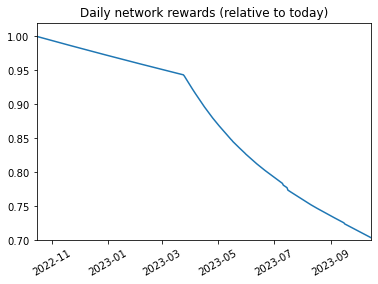

In [15]:
minting_df['date'] = pd.date_range(start=history_power_df['stateTime'][0], freq="d", periods=minting_df.shape[0])

plt.plot(minting_df['date'], minting_df['network_reward'] /  minting_df['network_reward'][2*365])
plt.xticks(rotation=30)
plt.xlim([datetime.date(2022, 10, 15), datetime.date(2023, 10, 15)])
plt.ylim(0.7,1.02)
plt.title("Daily network rewards (relative to today)")
plt.show()

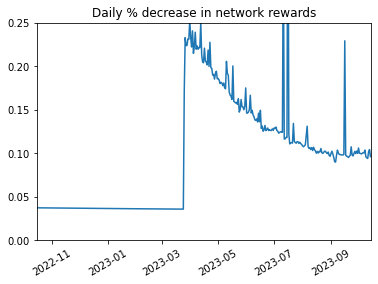

In [16]:
minting_df['network_reward_daily_change'] = np.insert(minting_df['network_reward'].diff()[1:].values, 0, minting_df['network_reward'].diff()[1:].values[0])

plt.plot(minting_df['date'], -100 * minting_df['network_reward_daily_change'] / minting_df['network_reward'])
plt.xticks(rotation=30)
plt.xlim([datetime.date(2022, 10, 15), datetime.date(2023, 10, 15)])
plt.ylim(0,0.25)
plt.title("Daily % decrease in network rewards")
plt.show()